# Imports

In [1]:
# standard libraries
import pandas as pd
import numpy as np

# visualization library
import altair as alt

# modeling libaries
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# enable altair visualizations
alt.renderers.enable()

# opaque background
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

# Load Data Functions

In [3]:
# function to reduce size of dataframes
def downcast_df(file):
    df = pd.read_csv(file)
    
    # isolate data types
    df_int = df.select_dtypes(include=['int64'])
    df_float = df.select_dtypes(include=['float64'])
    df_obj = df.select_dtypes(include=['object'])
    
    # downcast ints and floats
    df_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_float = df_float.apply(pd.to_numeric, downcast='float')
    
    # recombine into single dataframe
    optimized_df = df.copy()
    optimized_df[df_int.columns] = df_int
    optimized_df[df_float.columns] = df_float
    
    # return statement    
    return optimized_df

In [4]:
# function to print out df.info() and df.head() cleanly
def print_info(df):
    print(("=" * 10) + " Info " + ("=" * 10) + "\n")
    print(df.info())
    print("\n" + ("=" * 10) + " First 5 Rows " + ("=" * 10) + "\n")
    print(df.head())

# DataFrames

Loading all datasets, along with info (row data, memory usage), and first 5 rows of data. 

## Products

In [5]:
products = downcast_df('products.csv')
print_info(products)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null uint16
product_name     49688 non-null object
aisle_id         49688 non-null uint8
department_id    49688 non-null uint8
dtypes: object(1), uint16(1), uint8(2)
memory usage: 582.4+ KB
None

========== First 5 Rows ==========

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  


In [103]:
# product dictionaries for future usage in mapping
product_dict = dict(zip(products['product_name'], products['product_id']))
product_dict_inv = dict([v,k] for k,v in product_dict.items())

## Orders

In [6]:
orders = downcast_df('orders.csv')
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(-99)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('int16')
print_info(orders)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  uint32
user_id                   uint32
eval_set                  object
order_number              uint8
order_dow                 uint8
order_hour_of_day         uint8
days_since_prior_order    int16
dtypes: int16(1), object(1), uint32(2), uint8(3)
memory usage: 68.5+ MB
None

========== First 5 Rows ==========

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     -99  


## Aisles

In [7]:
aisles = downcast_df('aisles.csv')
print_info(aisles)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null uint8
aisle       134 non-null object
dtypes: object(1), uint8(1)
memory usage: 1.3+ KB
None

========== First 5 Rows ==========

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


## Departments

In [8]:
departments = downcast_df('departments.csv')
print_info(departments)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null uint8
department       21 non-null object
dtypes: object(1), uint8(1)
memory usage: 269.0+ bytes
None

========== First 5 Rows ==========

   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


## Prior Order Info

In [9]:
prior = downcast_df('order_products__prior.csv')
print_info(prior)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             uint32
product_id           uint16
add_to_cart_order    uint8
reordered            uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 247.5 MB
None

========== First 5 Rows ==========

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


## Training Data

In [10]:
train = downcast_df('order_products__train_cap.csv')
print_info(train)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038515 entries, 0 to 1038514
Data columns (total 4 columns):
order_id             1038515 non-null uint32
product_id           1038515 non-null uint16
add_to_cart_order    1038515 non-null uint8
reordered            1038515 non-null uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 7.9 MB
None

========== First 5 Rows ==========

   order_id  product_id  add_to_cart_order  reordered
0        36       39612                  1          0
1        36       19660                  2          1
2        36       49235                  3          0
3        36       43086                  4          1
4        36       46620                  5          1


## Test Data

In [11]:
test = downcast_df('order_products__test_cap.csv')
print_info(test)

========== Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346102 entries, 0 to 346101
Data columns (total 2 columns):
order_id      346102 non-null uint32
product_id    346102 non-null uint16
dtypes: uint16(1), uint32(1)
memory usage: 2.0 MB
None

========== First 5 Rows ==========

   order_id  product_id
0         1       49302
1         1       11109
2         1       10246
3         1       49683
4         1       43633


# Merge DFs

In [12]:
prior_merge1 = pd.merge(prior, products, on="product_id", how="left")
df = pd.merge(prior_merge1, orders, on="order_id", how="left")
df = df.drop(['eval_set'], axis=1)
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(-1).astype('int16')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8
2,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8
3,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8


In [13]:
product_count = df.groupby('product_id').size()

In [14]:
df['count'] = df['product_id'].map(product_count).astype('uint32')

In [15]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,count
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8,19400
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8,67449
2,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8,6299
3,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8,744
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8,569


In [16]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 13 columns):
order_id                  uint32
product_id                uint16
add_to_cart_order         uint8
reordered                 uint8
product_name              object
aisle_id                  uint8
department_id             uint8
user_id                   uint32
order_number              uint8
order_dow                 uint8
order_hour_of_day         uint8
days_since_prior_order    int16
count                     uint32
dtypes: int16(1), object(1), uint16(1), uint32(3), uint8(7)
memory usage: 3.4 GB


# Data Exploration

Exploration of various attributes of product and order data. 

## Time of Day

In [17]:
time_of_day = orders['order_hour_of_day'].value_counts()
time_of_day = time_of_day.reset_index()
time_of_day['pct_of_total'] = np.round((time_of_day['order_hour_of_day'] / time_of_day['order_hour_of_day'].sum()*100), 2)
# time_of_day.head()

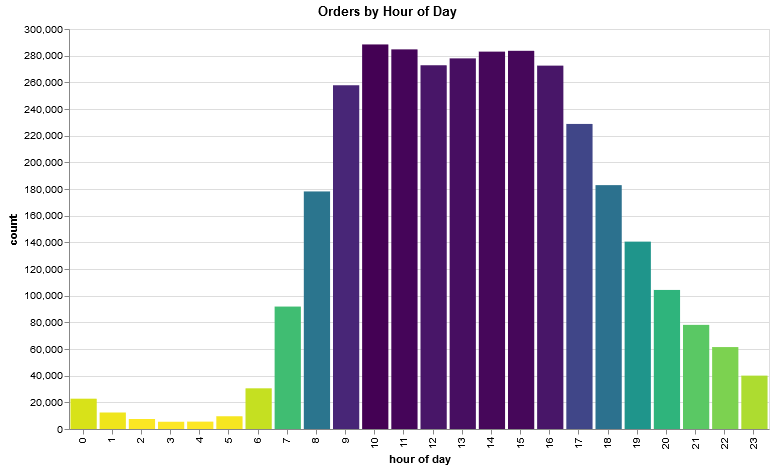

In [19]:
time_of_day_chart = alt.Chart(time_of_day).mark_bar().encode(
    alt.X("index:O", bin=False, title="hour of day"),
    alt.Y('order_hour_of_day:Q', title="count"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('order_hour_of_day', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('index:O', title="Hour of Day"), alt.Tooltip('order_hour_of_day:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Orders by Hour of Day", width=700, height=400)

time_of_day_chart

From this, we can see that most orders come in the 7am - 9pm timeframe, with heaviest demand from 9am - 5pm. 

## Orders by Day of Week

In [23]:
dayofweek_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 0}

inv_dayofweek_dict = {v: k for k, v in dayofweek_dict.items()}

dayofweek_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

In [24]:
dow = orders['order_dow'].value_counts()
dow = dow.reset_index()
dow.columns = ['index', 'count']
dow['pct_of_total'] = np.round((dow['count'] / dow['count'].sum()*100), 2)
dow['day'] = dow['index'].map(inv_dayofweek_dict)
# dow.head()

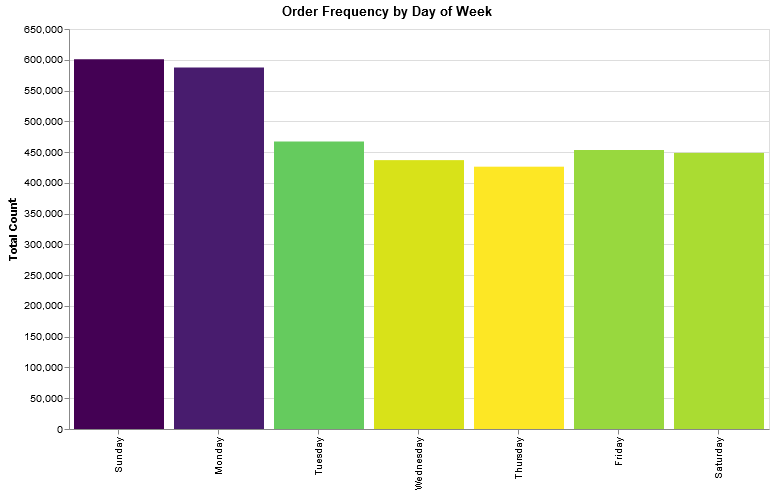

In [30]:
day_of_week_chart = alt.Chart(dow).mark_bar().encode(
    alt.X("day:O", bin=False, sort=dayofweek_list, title=""),
    alt.Y('count:Q', title="Total Count"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('count', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('day:O', title="Day of Week"), alt.Tooltip('count:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Order Frequency by Day of Week", width=700, height=400)

day_of_week_chart

From this chart, we can see that orders are spread out reasonably well over the week, but Sunday and Monday are the busiest days, account for ~ 34% of all orders. Differences between Tuesday thru Saturday appear to be neglible, so we can think of the week in terms of two categories: Sunday + Monday (peak days) and Tues - Sat.   

## Days Since Last Order

In [27]:
days_since_prior = orders['days_since_prior_order'].value_counts()
days_since_prior = days_since_prior.reset_index()
days_since_prior.columns = ['days_since_prior_order', 'count']
days_since_prior = days_since_prior.sort_values(by=['days_since_prior_order'])
days_since_prior = days_since_prior.drop(6, axis=0)
days_since_prior = days_since_prior.reset_index(drop=True)
# days_since_prior = days_since_prior.drop('index', axis=1)
# days_since_prior = days_since_prior.reset_index()
days_since_prior['pct_of_total'] = np.round((days_since_prior['count'] / days_since_prior['count'].sum()*100), 2)
# days_since_prior.head()

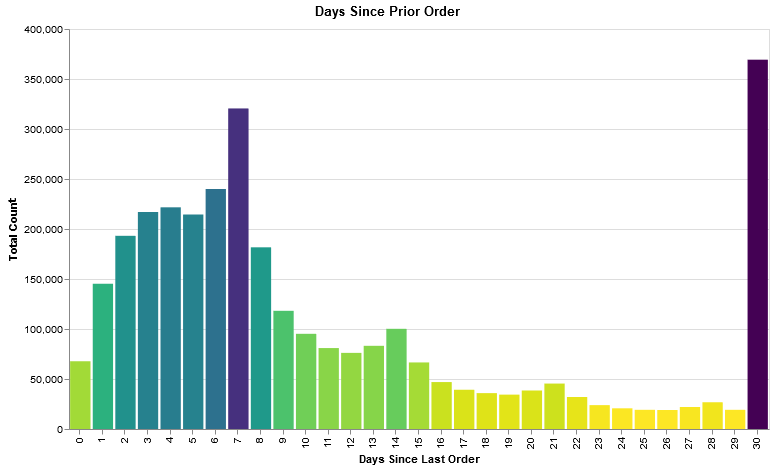

In [29]:
prev_order_chart = alt.Chart(days_since_prior).mark_bar().encode(
    alt.X("days_since_prior_order:O", bin=False, title="Days Since Last Order"),
    alt.Y('count:Q', title="Total Count"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color('count', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('days_since_prior_order:Q', title="Days since Last Order"), alt.Tooltip('count:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Days Since Prior Order", width=700, height=400)

prev_order_chart

The most interesting observation here is that ~ 10% of customers reorder exactly 7 days after their prior order. Approximately 50% of customers reorder within 7 days. 

## Orders by Department

In [34]:
dept_stats = df['department_id'].value_counts().reset_index()
dept_stats.columns = ['department_id', 'freq']
dept_stats = pd.merge(dept_stats, departments, on='department_id', how='left')
dept_stats['pct_orders'] = np.round((dept_stats['freq'] / dept_stats['freq'].sum()) * 100,2)
# dept_stats

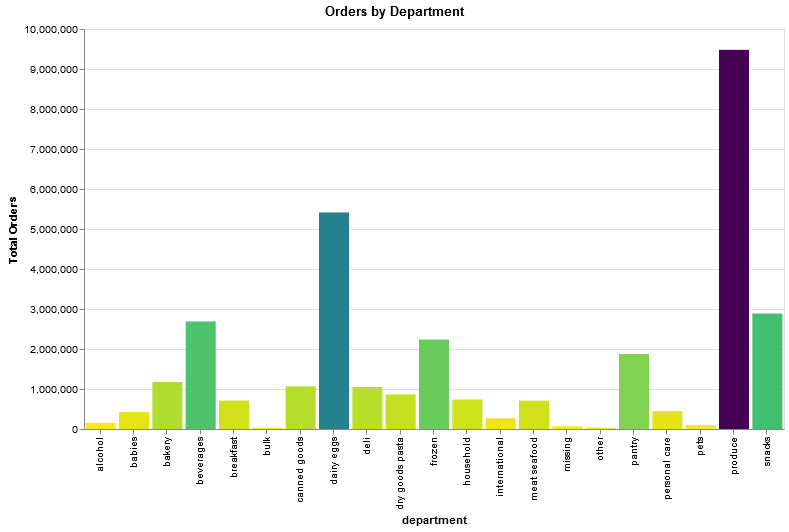

In [35]:
chart_title = "Orders by Department"
x_label = "department:O"
y_label = 'freq:Q'
pct_of_orders = 'pct_orders:Q'
# sort_list = honeycrisp_df['index'].tolist()


dept_chart = alt.Chart(dept_stats).mark_bar().encode(
    alt.X(x_label, bin=False),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Department"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders)]
    ).properties(title=chart_title, width=700, height=400)

dept_chart

Produce dominates this category, accounting for roughly 29% of all items purchased. Dairy + eggs are 2nd most popular department, accounting for ~ 17% of items purchased. 

## Most Popular Products

In [37]:
# 20 most commonly ordered products
df['product_name'].value_counts()[:20]

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_name, dtype: int64

In [145]:
num_orders = orders.shape[0]

top_prods = df['product_name'].value_counts()[:30]
top_prods = pd.DataFrame(top_prods).reset_index()
top_prods.columns = ['index', 'count']
top_prods['product_num'] = top_prods['index'].map(product_dict)
top_prods['Pct_of_Baskets'] = (top_prods['count'] / num_orders) * 100

In [40]:
top_prods.head()

,index,count,product_num,Pct_of_Baskets
0,Banana,472565,24852,13.813316
1,Bag of Organic Bananas,379450,13176,11.091517
2,Organic Strawberries,264683,21137,7.736819
3,Organic Baby Spinach,241921,21903,7.071474
4,Organic Hass Avocado,213584,47209,6.243169


In [41]:
top_prods_order_list = top_prods['index'].tolist()

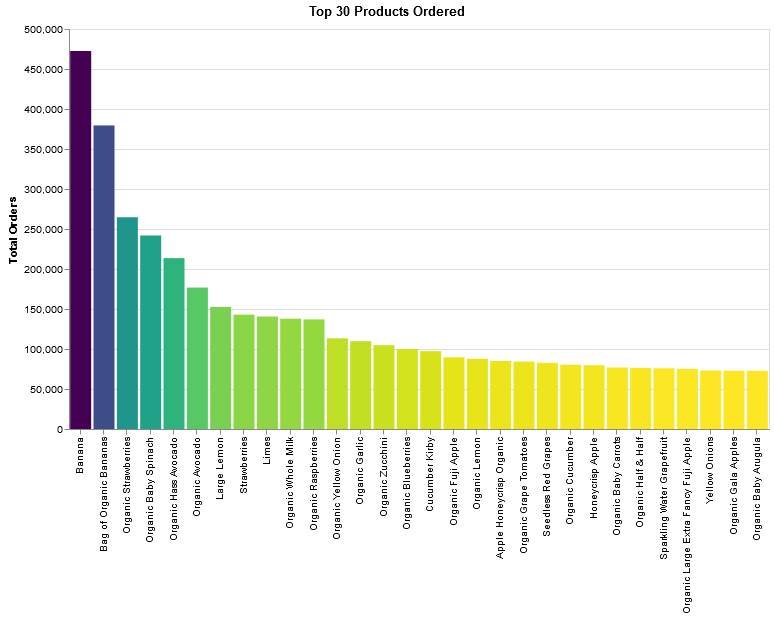

In [43]:
chart_title = "Top 30 Products Ordered"
x_label = "index:O"
y_label = 'count:Q'
pct_of_baskets = 'Pct_of_Baskets:Q'
product_num = 'product_num:O'

top_30_chart = alt.Chart(top_prods).mark_bar().encode(
    alt.X(x_label, bin=False, sort=top_prods_order_list, title=""),
    alt.Y(y_label, title="Total Orders"),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Product"), alt.Tooltip(y_label), alt.Tooltip(pct_of_baskets), alt.Tooltip(product_num)]
    ).properties(title=chart_title, width=700, height=400)

top_30_chart

Regular bananas are ordered in a whopping 13% of baskets, while organic bananas are ordered in 11%. There's a significant dropoff by the time we reach the 30th most popular item (organic baby arugla), which is in 2% of baskets. Produce items dominate the top 30 products. 

In [146]:
# create dictionary for market basket % for every product

all_prods = df['product_name'].value_counts()
all_prods = pd.DataFrame(all_prods).reset_index()
all_prods.columns = ['index', 'count']
all_prods['product_id'] = all_prods['index'].map(product_dict)
all_prods['pct_pop_orders'] = (all_prods['count'] / num_orders) * 100

pct_order_dict = pd.Series(all_prods['pct_pop_orders'].values,index=all_prods['product_id']).to_dict()

## Item Order Frequency

In [45]:
products['count'] = products['product_id'].map(product_count).fillna(0).astype('uint32')

In [46]:
bin_labels = ['0-5', '6-20', '21-50','51-100','101-500','501-2500','2500-10000', '10001-50000', '50000+']
bins = [0, 6, 21, 51, 101, 501, 2501,10001, 50001, 500000]

products['count_bin'] = pd.cut(products['count'], bins, labels=bin_labels)

In [47]:
prod_count_bins = pd.DataFrame(products['count_bin'].value_counts())
prod_count_bins = prod_count_bins.reset_index()
prod_count_bins.columns = ['bin', 'count']
prod_count_bins['pct_total'] = np.round((prod_count_bins['count'] / prod_count_bins['count'].sum()) * 100,2)
prod_count_bins

,bin,count,pct_total
0,101-500,11614,23.38
1,6-20,10473,21.08
2,21-50,8689,17.49
3,51-100,6397,12.88
4,501-2500,5997,12.07
5,0-5,4234,8.52
6,2500-10000,1781,3.59
7,10001-50000,432,0.87
8,50000+,60,0.12


In [48]:
chart_title = "Total Orders for Products (grouped by bins)"
x_label = "bin:O"
y_label = 'count:Q'
pct_total = 'pct_total:Q'


bin_chart = alt.Chart(prod_count_bins).mark_bar().encode(
    alt.X(x_label, title="Bin (Total Orders)", sort=bin_labels),
    alt.Y(y_label, title="Number of Products"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')), 
    tooltip=[alt.Tooltip(x_label, title="Bin"), alt.Tooltip(y_label), alt.Tooltip(pct_total)]
    ).properties(title=chart_title, width=700, height=400)

What this visualization tells us is that the majority of products are ordered between 0 - 100 times. Products ordered more than 10,000 times are rare (about 1% of total products) and even products ordered more than 2,500 times make up a small percentage (~ 5%) of the total number of products.

Items ordered 5 or fewer times account for 8.5% of total products and products ordered fewer than 20 times account for roughly 30% of products. A sizable percentage (~ 23%) of products are ordered between 100 and 500 times. 

# Associations

## Items Most Frequently Ordered with Organic Strawberries

In [161]:
ords_org_strawberries = df[df['product_id'] == 21137]['order_id'].tolist()
# ords_org_strawberries[:10]

In [162]:
org_strawberry_df = df[df['order_id'].isin(ords_org_strawberries)]

In [163]:
# top 30 items ordered with organic strawberries
num_org_strawb = org_strawberry_df['product_name'].value_counts()[0]
top_items_org_strawb = org_strawberry_df['product_name'].value_counts()[1:31]
top_items_org_strawb

Bag of Organic Bananas                  61628
Banana                                  56156
Organic Hass Avocado                    40794
Organic Baby Spinach                    38134
Organic Raspberries                     33863
Organic Avocado                         23984
Organic Whole Milk                      23813
Organic Blueberries                     23756
Limes                                   18999
Organic Yellow Onion                    16651
Organic Cucumber                        16555
Large Lemon                             16305
Apple Honeycrisp Organic                15870
Organic Garlic                          15627
Organic Grape Tomatoes                  15573
Organic Zucchini                        15320
Organic Lemon                           15152
Organic Large Extra Fancy Fuji Apple    15113
Seedless Red Grapes                     13935
Organic Whole String Cheese             13513
Organic Gala Apples                     13298
Organic Baby Carrots              

In [166]:
top_items_org_strawb_df = pd.DataFrame(top_items_org_strawb)
top_items_org_strawb_df = top_items_org_strawb_df.reset_index()
top_items_org_strawb_df.columns = ['index', 'count']
top_items_org_strawb_df['pct_orders'] = np.round((top_items_org_strawb_df['count'] / num_org_strawb) * 100,2)
top_items_org_strawb_df['product_id'] = top_items_org_strawb_df['index'].map(product_dict)
top_items_org_strawb_df['pop_pct_orders'] = top_items_org_strawb_df['product_id'].map(pct_order_dict)
top_items_org_strawb_df['purchase_ratio'] = np.round(top_items_org_strawb_df['pct_orders'] / top_items_org_strawb_df['pop_pct_orders'], 2)
top_items_org_strawb_df.head(20)

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Bag of Organic Bananas,61628,23.28,13176,11.091517,2.10
1,Banana,56156,21.22,24852,13.813316,1.54
2,Organic Hass Avocado,40794,15.41,47209,6.243169,2.47
3,Organic Baby Spinach,38134,14.41,21903,7.071474,2.04
4,Organic Raspberries,33863,12.79,27966,4.006246,3.19
5,Organic Avocado,23984,9.06,47766,5.168393,1.75
6,Organic Whole Milk,23813,9.00,27845,4.031033,2.23
7,Organic Blueberries,23756,8.98,39275,2.924805,3.07
8,Limes,18999,7.18,26209,4.110599,1.75
9,Organic Yellow Onion,16651,6.29,22935,3.315500,1.90


In [168]:
org_straw_order_list = top_items_org_strawb_df['index'].tolist()
# org_straw_order_list

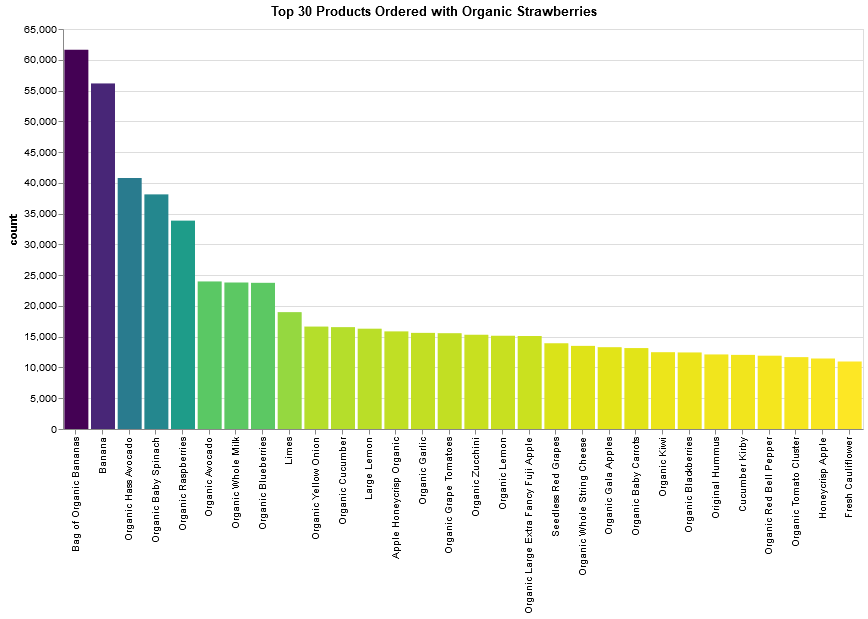

In [169]:
chart_title = "Top 30 Products Ordered with Organic Strawberries"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'

strawberry_chart = alt.Chart(top_items_org_strawb_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=org_straw_order_list, title=""),
    alt.Y(y_label),
#     alt.ColorValue('darkorange'),
#     color = alt.Color('order_hour_of_day', alt.ColorValue("blue")),
#     color='orange',
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num), alt.Tooltip(multiple, title="purchase ratio")]
    ).properties(title=chart_title, width=800, height=400)

strawberry_chart

In [170]:
strawberry_chart.save('strawberry.html')

## Items Most Frequently Ordered with Honeycrisp Apples

In [142]:
# find top n items ordered with any particular product by product_id
def top_n_items(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    # top 30 items ordered with organic strawberries
    num_of_main_item = orders_with_item['product_name'].value_counts()[0]
    top_items_with_item = orders_with_item['product_name'].value_counts()[1:n+1]

    top_items_with_item = pd.DataFrame(top_items_with_item)
    top_items_with_item = top_items_with_item.reset_index()
    top_items_with_item.columns = ['index', 'count']
    top_items_with_item['pct_orders'] = np.round((top_items_with_item['count'] / num_of_main_item) * 100, 2)
    top_items_with_item['product_id'] = top_items_with_item['index'].map(product_dict)

    top_items_order_list = top_items_with_item['index'].tolist()
    
    return top_items_with_item

In [157]:
# top 10 items ordered with honeycrisp apples
honeycrisp_df = top_n_items(df, 45066, 20)
honeycrisp_df['pop_pct_orders'] = honeycrisp_df['product_id'].map(pct_order_dict)
honeycrisp_df['purchase_ratio'] = np.round(honeycrisp_df['pct_orders'] / honeycrisp_df['pop_pct_orders'], 2)
honeycrisp_df

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Banana,28408,35.61,24852,13.813316,2.58
1,Organic Strawberries,11465,14.37,21137,7.736819,1.86
2,Bag of Organic Bananas,11137,13.96,13176,11.091517,1.26
3,Organic Avocado,11046,13.85,47766,5.168393,2.68
4,Organic Baby Spinach,10170,12.75,21903,7.071474,1.80
5,Large Lemon,9485,11.89,47626,4.462242,2.66
6,Organic Hass Avocado,8100,10.15,47209,6.243169,1.63
7,Strawberries,7536,9.45,16797,4.178531,2.26
8,Limes,6993,8.77,26209,4.110599,2.13
9,Cucumber Kirby,6518,8.17,49683,2.844567,2.87


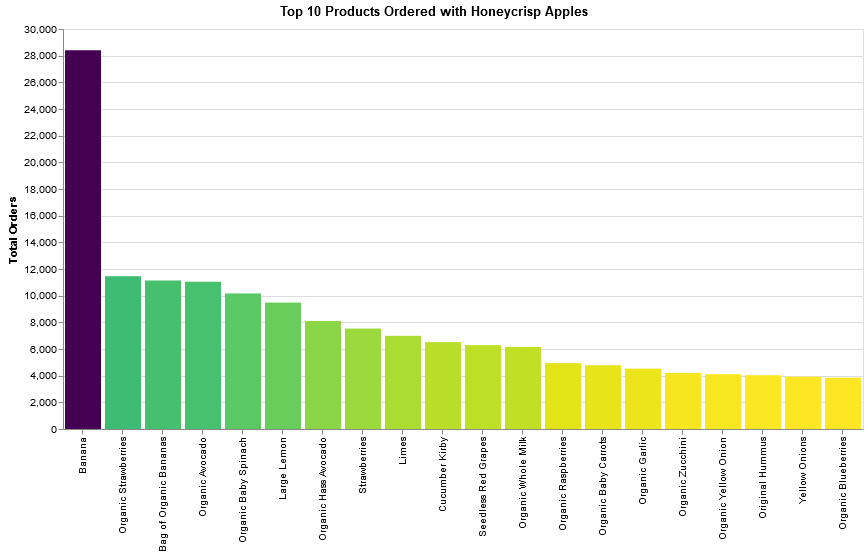

In [159]:
chart_title = "Top 10 Products Ordered with Honeycrisp Apples"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'
sort_list = honeycrisp_df['index'].tolist()


honeycrisp_chart = alt.Chart(honeycrisp_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=sort_list, title=""),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num), alt.Tooltip(multiple, title="purchase ratio")]
    ).properties(title=chart_title, width=800, height=400)

honeycrisp_chart

In [171]:
honeycrisp_chart.save('honeycrisp.html')

## Items Most Frequently Ordered with Organic Turkey Burgers

In [153]:
# top 20 items ordered with honeycrisp apples
org_turkey_burger_df = top_n_items(df, 23, 20)
org_turkey_burger_df['pop_pct_orders'] = org_turkey_burger_df['product_id'].map(pct_order_dict)
org_turkey_burger_df['purchase_ratio'] = np.round(org_turkey_burger_df['pct_orders'] / org_turkey_burger_df['pop_pct_orders'],2)
org_turkey_burger_df

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Banana,179,16.76,24852,13.813316,1.21
1,Bag of Organic Bananas,172,16.10,13176,11.091517,1.45
2,Organic Strawberries,169,15.82,21137,7.736819,2.04
3,Organic Baby Spinach,151,14.14,21903,7.071474,2.00
4,Organic Hass Avocado,135,12.64,47209,6.243169,2.02
5,Organic Avocado,114,10.67,47766,5.168393,2.06
6,Organic Raspberries,101,9.46,27966,4.006246,2.36
7,Organic Baby Carrots,99,9.27,42265,2.247709,4.12
8,Organic Zucchini,82,7.68,45007,3.064030,2.51
9,Large Lemon,75,7.02,47626,4.462242,1.57


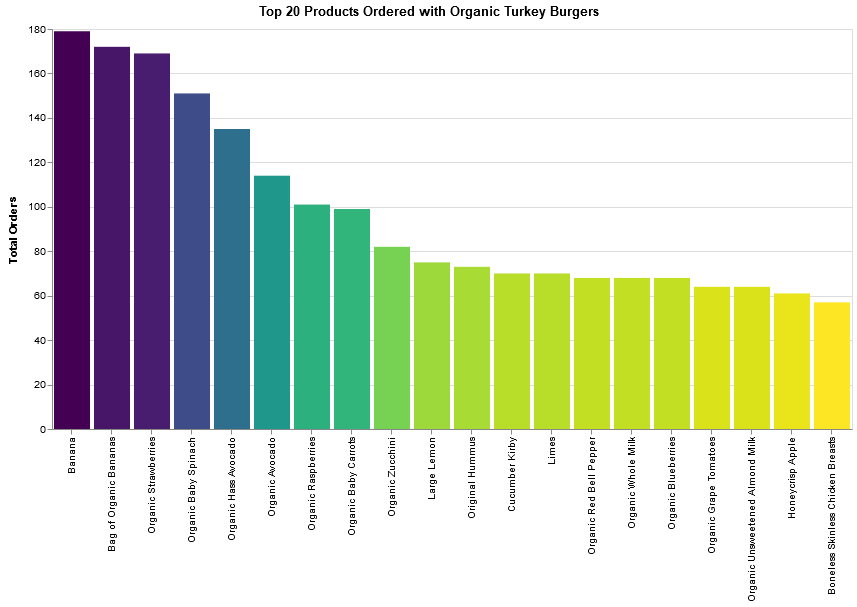

In [155]:
chart_title = "Top 20 Products Ordered with Organic Turkey Burgers"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'
sort_list = org_turkey_burger_df['index'].tolist()


turkey_chart = alt.Chart(org_turkey_burger_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=sort_list, title=""),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders, title="% of Orders"), 
             alt.Tooltip(product_num), alt.Tooltip(multiple, title="purchase ratio")]
    ).properties(title=chart_title, width=800, height=400)

turkey_chart

In [172]:
turkey_chart.save('turkey.html')

# Similar Products (Cosine Similarity)

In [86]:
train.shape

(1038515, 4)

In [18]:
train_sm = train[:100000].copy()
# train_sm['order'] = 1
# train_sm['order'] = train_sm['order'].astype('uint8')
train_sm.head()

,order_id,product_id,add_to_cart_order,reordered
0,36,39612,1,0
1,36,19660,2,1
2,36,49235,3,0
3,36,43086,4,1
4,36,46620,5,1


In [19]:
train_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
order_id             100000 non-null uint32
product_id           100000 non-null uint16
add_to_cart_order    100000 non-null uint8
reordered            100000 non-null uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 781.3 KB


In [53]:
# train.pivot(index='product_id', columns='order_id', values='reordered')

In [20]:
productPivot = train_sm.pivot(index='product_id', columns='order_id', values='reordered')

In [21]:
productPivot[productPivot.notnull()] = 1
productPivot[productPivot.isnull()] = 0

In [22]:
productPivot.head()

order_id,36,38,170,226,349,456,719,762,844,878,...,325777,325802,325849,325885,325939,326057,326060,326138,326225,326238
product_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
productPivot.shape

(16635, 9402)

In [67]:
np.where(productPivot.index == 1)[0][0]

0

In [71]:
product_sim_matrix[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [24]:
product_sim_matrix = cosine_similarity(productPivot)

In [89]:
def find_similar_items(prod_id, matrix, n):
    
    index_num = np.where(productPivot.index == prod_id)[0][0]
    
    match_list = []
    score_list = []
    
    matrix = matrix[index_num]
    
    for i in range(len(matrix)):
        if matrix[i] > 0.05 and matrix[i] < 0.99:
            match_list.append(i)
            score_list.append(matrix[i])
            
    order_match_list = productPivot[productPivot.reset_index().index.isin(match_list)].index.values.tolist()
      
    df = products[products['product_id'].isin(order_match_list)].copy()
    df['sim_score'] = score_list
    df = df.sort_values(by=['sim_score'], ascending=False)
    df = df[:n]
    
    return df

In [75]:
productPivot[:5]

order_id,36,38,170,226,349,456,719,762,844,878,...,325777,325802,325849,325885,325939,326057,326060,326138,326225,326238
product_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
products[products['product_id'] == 1]

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19


In [85]:
# similarity to chocolate sandwich cookies
find_similar_items(1, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,sim_score
24069,24070,Spicy Homestyle Guacamole,1,20,0.333333
29872,29873,Morena Pure Cane Sugar,17,13,0.333333
39812,39813,Rice Sea Salt & Pepper Snacks,78,19,0.333333
10961,10962,Extra Strength Energy Shot,64,7,0.333333
11303,11304,Ground Black Silk Dark Coffee,26,7,0.333333
13819,13820,Peanut Butter Cookies,8,3,0.333333
16304,16305,Ritz Crackers,78,19,0.333333
33739,33740,"Cara Cara Oranges, Bag",24,4,0.333333
33637,33638,Mint Rolls,46,19,0.333333
43961,43962,Coleslaw,123,4,0.235702


In [90]:
# organic turkey burgers
find_similar_items(23, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,sim_score
32332,32333,Apple + Banana Fruit Bar,3,19,0.577350
24582,24583,Organic Unsweetened & Salt Free Sunflower See...,88,13,0.577350
43634,43635,Whole Milk Greek Plain,120,16,0.408248
35126,35127,Matcha Almondmilk,31,7,0.333333
46324,46325,Original Sparkling Water,115,7,0.333333
29573,29574,Tempt Unsweetened Vanilla Hemp Milk,91,16,0.288675
25019,25020,Organic Banana Chips,50,19,0.288675
275,276,French Vanilla Ice Cream,37,1,0.258199
20167,20168,Organic Sunflower Seed Spread,88,13,0.235702
22720,22721,Creamy Peanut Butter Dark Roasted,88,13,0.218218


In [91]:
# boneless skinless chicken breasts
find_similar_items(25890, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,sim_score
24851,24852,Banana,24,4,0.114097
21680,21681,Sriracha Sauce,72,13,0.100000
47765,47766,Organic Avocado,24,4,0.097219
13995,13996,Giant Peach,94,7,0.094281
40344,40345,Gluten-Free Smart Puffs Real Wisconsin Cheddar...,107,19,0.094281
40724,40725,Gluten Free Fusilli Brown Rice Pasta,131,9,0.094281
1823,1824,"Frozen Desserts, Cookies and Cream",37,1,0.094281
13197,13198,85% Lean Ground Beef,122,12,0.093314
49682,49683,Cucumber Kirby,83,4,0.091035
12871,12872,Penne Rigate,131,9,0.090972


In [92]:
# honeycrisp apples
find_similar_items(45066, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,sim_score
24851,24852,Banana,24,4,0.161047
47625,47626,Large Lemon,24,4,0.119579
36286,36287,Smooth Operator Natural Peanut Butter,88,13,0.099960
21136,21137,Organic Strawberries,24,4,0.091123
13175,13176,Bag of Organic Bananas,24,4,0.083088
8423,8424,Broccoli Crown,83,4,0.082190
47765,47766,Organic Avocado,24,4,0.081614
47208,47209,Organic Hass Avocado,24,4,0.081300
16796,16797,Strawberries,24,4,0.080572
21902,21903,Organic Baby Spinach,123,4,0.080244


# Similar Baskets (Cosine Similiarity)

In [108]:
train_200k = train[:200000].copy()

In [109]:
orderPivot = train_200k.pivot(index='order_id', columns='product_id', values='reordered')

In [110]:
orderPivot[orderPivot.notnull()] = 1
orderPivot[orderPivot.isnull()] = 0

In [111]:
orderPivot.shape

(18874, 22376)

In [112]:
order_sim_matrix = cosine_similarity(orderPivot)

In [134]:
def find_similar_baskets(matrix):
    match_list = []

    for i in range(len(matrix)):
        if matrix[i] > 0.1 and matrix[i] < 0.99:
            match_list.append(i)
            
    order_match_list = orderPivot[orderPivot.reset_index().index.isin(match_list)].index.values.tolist()
    
    return order_match_list

In [ ]:
# def find_similar_baskets(order_id):
#     match_list = []

#     for i in range(len(matrix)):
#         if matrix[i] > 0.2 and matrix[i] < 0.99:
#             match_list.append(i)
            
#     order_match_list = orderPivot[orderPivot.reset_index().index.isin(match_list)].index.values.tolist()
    
#     return order_match_list

In [122]:
matched_baskets = find_similar_baskets(order_sim_matrix[0])

In [104]:
sample_order = train_sm[train_sm['order_id']==36].copy()
sample_order['product_name'] = sample_order['product_id'].map(product_dict_inv)
sample_order

,order_id,product_id,add_to_cart_order,reordered,product_name
0,36,39612,1,0,Grated Pecorino Romano Cheese
1,36,19660,2,1,Spring Water
2,36,49235,3,0,Organic Half & Half
3,36,43086,4,1,Super Greens Salad
4,36,46620,5,1,Cage Free Extra Large Grade AA Eggs
5,36,34497,6,1,"Prosciutto, Americano"
6,36,48679,7,1,Organic Garnet Sweet Potato (Yam)
7,36,46979,8,1,Asparagus


In [105]:
sample_order_list = sample_order['product_id'].tolist()
sample_order_list

[39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979]

In [125]:
matching_vals = pd.DataFrame(train_sm[train_sm['order_id'].isin(matched_baskets)]['product_id'].value_counts())
matching_vals = matching_vals.reset_index()
matching_vals.columns = ['product_id', 'count']
matching_vals['product_name'] = matching_vals['product_id'].map(product_dict_inv)
matching_vals[matching_vals['product_id'].isin(sample_order_list) == False][:10]

,product_id,count,product_name
5,21137,3,Organic Strawberries
6,47766,2,Organic Avocado
7,2078,2,Unsalted Pure Irish Butter
8,22935,2,Organic Yellow Onion
9,47626,2,Large Lemon
10,21903,2,Organic Baby Spinach
11,45007,2,Organic Zucchini
12,14999,2,Grade A Large Brown Eggs
13,8424,2,Broccoli Crown
14,47209,2,Organic Hass Avocado


### Another Sample

In [135]:
matched_baskets2 = find_similar_baskets(order_sim_matrix[10])

In [136]:
sample_order2 = train_sm[train_sm['order_id']==878].copy()
sample_order2['product_name'] = sample_order2['product_id'].map(product_dict_inv)
sample_order2

,order_id,product_id,add_to_cart_order,reordered,product_name
79,878,48070,1,1,Chocolate Mint Crisp Protein Bar
80,878,24852,2,1,Banana
81,878,23044,3,0,Cream Top Smooth & Creamy Vanilla Yogurt
82,878,45066,4,1,Honeycrisp Apple
83,878,21903,5,1,Organic Baby Spinach
84,878,24964,6,0,Organic Garlic
85,878,47209,7,1,Organic Hass Avocado
86,878,40706,8,0,Organic Grape Tomatoes
87,878,21616,9,0,Organic Baby Arugula
88,878,10305,10,0,Black Plum


In [137]:
sample_order_list2 = sample_order2['product_id'].tolist()
# sample_order_list2

In [140]:
matching_vals2 = pd.DataFrame(train_sm[train_sm['order_id'].isin(matched_baskets2)]['product_id'].value_counts())
matching_vals2 = matching_vals2.reset_index()
matching_vals2.columns = ['product_id', 'count']
matching_vals2['product_name'] = matching_vals2['product_id'].map(product_dict_inv)
matching_vals2[matching_vals2['product_id'].isin(sample_order_list2) == False][:10]
# matching_vals2

,product_id,count,product_name
0,196,72,Soda
1,43352,6,Raspberries
2,46149,4,Zero Calorie Cola
3,37710,4,Trail Mix
4,40939,4,Drinking Water
5,41400,4,Crunchy Oats 'n Honey Granola Bars
6,13966,3,Chicken Pot Pie
7,22395,3,Tomato Sauce
8,29529,3,Lemon-Lime Soda
9,6184,3,Clementines


# Old Code --- Ignore

In [218]:
sample_matrix = cosine_similarity(productPivot)[0]

In [239]:
sample_matrix

array([1., 0., 0., ..., 0., 0., 0.])

In [270]:
match_list = []

for i in range(len(sample_matrix)):
    if sample_matrix[i] > 0.3:
        match_list.append(i)
        
# match_list.pop(0)

In [271]:
match_list[:10]

[0, 436, 1709, 1766, 2024, 2052, 2787, 2865, 3056, 3334]

In [282]:
order_match_list = productPivot[productPivot.reset_index().index.isin(match_list)].index.values.tolist()
order_match_list.pop(0)

36

In [283]:
order_match_list

[15462,
 59410,
 61237,
 70422,
 71360,
 97360,
 99543,
 107203,
 116215,
 124424,
 127086,
 129823,
 132320,
 144837,
 150605,
 150721,
 153794,
 158030,
 294266,
 303380]

In [265]:
train_sm[train_sm['order_id'].isin(order_match_list)]['product_id'].value_counts()

19660    13
49235     6
46979     2
30557     1
19354     1
49401     1
21137     1
27086     1
48679     1
31717     1
44449     1
Name: product_id, dtype: int64

In [278]:
sample_order = train_sm[train_sm['order_id']==36].copy()
sample_order['product_name'] = sample_order['product_id'].map(product_dict_inv)
sample_order

,order_id,product_id,add_to_cart_order,reordered,product_name
0,36,39612,1,0,Grated Pecorino Romano Cheese
1,36,19660,2,1,Spring Water
2,36,49235,3,0,Organic Half & Half
3,36,43086,4,1,Super Greens Salad
4,36,46620,5,1,Cage Free Extra Large Grade AA Eggs
5,36,34497,6,1,"Prosciutto, Americano"
6,36,48679,7,1,Organic Garnet Sweet Potato (Yam)
7,36,46979,8,1,Asparagus


In [284]:
matching_vals = pd.DataFrame(train_sm[train_sm['order_id'].isin(order_match_list)]['product_id'].value_counts())
matching_vals = matching_vals.reset_index()
matching_vals.columns = ['index', 'count']
matching_vals['product_name'] = matching_vals['index'].map(product_dict_inv)
matching_vals

,index,count,product_name
0,19660,13,Spring Water
1,49235,6,Organic Half & Half
2,46979,2,Asparagus
3,30557,1,Manzano Banana
4,19354,1,Yo Baby Organic Vanilla Yogurt
5,49401,1,"Chicken Base, Organic"
6,21137,1,Organic Strawberries
7,27086,1,Half & Half
8,48679,1,Organic Garnet Sweet Potato (Yam)
9,31717,1,Organic Cilantro


In [208]:
cosine_similarity(productPivot[:500])[0][436]

0.35355339059327373

In [205]:
len(cosine_similarity(productPivot[:500])[0])

500

In [194]:
productPivot[22:23]

product_id,1,3,4,9,10,23,25,28,29,30,...,49644,49652,49653,49667,49668,49670,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
1275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
productPivot[436:437]

product_id,1,3,4,9,10,23,25,28,29,30,...,49644,49652,49653,49667,49668,49670,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
15462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
productPivot.loc[1275][productPivot.loc[1275] == 1]

product_id
5450     1.0
6046     1.0
18761    1.0
31506    1.0
48679    1.0
Name: 1275, dtype: float64

In [198]:
productPivot.loc[15462][productPivot.loc[15462] == 1]

product_id
19660    1.0
Name: 15462, dtype: float64

In [48]:
productPivot[45066].head(15)

order_id
36      0.0
38      0.0
170     0.0
226     0.0
349     0.0
456     0.0
719     0.0
762     0.0
844     0.0
878     1.0
915     0.0
988     0.0
1001    0.0
1032    0.0
1042    0.0
Name: 45066, dtype: float64

In [49]:
# bananas
bananas = productPivot[24852]
honeycrisp = productPivot[45066]

In [54]:
train_sm['product_id'].value_counts()[:20]

24852    1332
13176    1151
21137     801
21903     724
47626     604
47766     553
47209     523
16797     466
26209     407
27966     383
27845     374
39275     351
30391     347
45007     320
22935     303
4920      295
8518      291
40706     291
24964     285
42265     284
Name: product_id, dtype: int64

In [50]:
train_sm.groupby('product_id').size()

product_id
1          9
3          1
4          1
9          1
10        14
23         3
25         4
28         1
29         1
30         1
32         2
34        20
36         2
37         3
40         1
41         1
43         1
45        51
47         3
48         1
49        13
54         5
55         1
58         2
62         1
63         5
70         2
77         1
79        10
83         2
        ... 
49593      1
49597      1
49600      2
49602      1
49604      1
49605     24
49608      5
49609      3
49610     27
49611      1
49615      5
49618      2
49621     11
49622      1
49628     16
49633      1
49636      1
49637      3
49638      1
49640      1
49644      2
49652      2
49653      1
49667      7
49668      2
49670      1
49678      1
49680      3
49683    181
49686      1
Length: 16635, dtype: int64

In [55]:
# items similar to honeycrisp apples
similarItems = productPivot.corrwith(honeycrisp)
# similarItems
# similarItems.shape
similarItems = similarItems.dropna()
similarItemsDF = pd.DataFrame(similarItems)
similarItemsDF = pd.merge(similarItemsDF, products, on="product_id", how="inner")
similarItemsDF.columns = ['product_id', 'corr', 'product_name', 'aisle_id', 'department_id']
# similarItemsDF['count'] = df.groupby('product_id')['order'].size()
# similarItemsDF['count'] = train_sm.groupby('product_id').size()

In [56]:
similarItemsDF[30:40]

,product_id,corr,product_name,aisle_id,department_id
30,93,-0.003601,Uncured Cracked Pepper Beef,23,19
31,95,-0.004411,Organic Rice Vinegar,66,6
32,99,-0.003119,Local Living Butter Lettuce,83,4
33,100,-0.001800,Peanut Butter & Strawberry Jam Sandwich,38,1
34,106,-0.003601,Organic Yummy Tummy Maple & Brown Sugar Instan...,92,18
35,113,-0.002546,Infant's Blend Probiotic,70,11
36,115,-0.002546,Scooby-Doo! Fruit Flavored Snacks,50,19
37,116,-0.004765,English Muffins,93,3
38,117,-0.006978,Petit Suisse Fruit,2,16
39,118,-0.001800,Ground Turkey Chub,34,1


In [59]:
similarItemsDF.sort_values(by=['corr'], ascending=False)[:10]

,product_id,corr,product_name,aisle_id,department_id
15047,45066,1.000000,Honeycrisp Apple,24,4
8318,24852,0.105542,Banana,24,4
12170,36287,0.096117,Smooth Operator Natural Peanut Butter,88,13
15934,47626,0.079749,Large Lemon,24,4
5012,14917,0.070179,Blackberry Yogurt,120,16
11776,35147,0.067194,Medium Roast Whole Bean Coffee,26,7
9937,29691,0.067194,Petite Butter Croissant,43,3
1086,3283,0.067194,Peanut Butter Creme Cookies,61,19
13566,40530,0.067194,Soothing Caramel Bedtime Tea,94,7
5346,15925,0.067194,Macaroni and Cheese,38,1


In [114]:
# df.groupby('product_id').agg({'reordered': {np.size}})

In [113]:
counts = df.groupby('product_id').agg({'reordered': {np.size}})
counts[:20]

,reordered
,size
product_id,
1,1852
2,90
3,277
4,329
5,15
6,8
7,30
8,165


In [144]:
count = train_sm.groupby('product_id').size()
count_dict = count.to_dict()
count[:10]

product_id
1      2
3      1
9      1
10     8
23     2
25     1
29     1
34    10
36     1
37     2
dtype: int64

In [147]:
count.describe()

count    11971.000000
mean         4.176761
std         14.267705
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        668.000000
dtype: float64

In [148]:
similarItemsDF['total_count'] = similarItemsDF['product_id'].map(count_dict).astype('int')

In [149]:
similarItemsDF.head()

,product_id,corr,product_name,aisle_id,department_id,count,total_count
0,45,0.447214,European Cucumber,83,4,NaN,25
1,432,-0.500000,Vanilla Almond Breeze Almond Milk,91,16,1852.0,42
2,1158,0.408248,Mango Chunks,116,1,90.0,29
3,1999,-1.000000,Organic Chicken Broth,69,15,277.0,24
4,2078,0.500000,Unsalted Pure Irish Butter,36,16,329.0,25


In [153]:
popularItems = similarItemsDF[similarItemsDF['total_count'] >= 20]

In [156]:
popularItems.sort_values(by=['corr'], ascending=False)[:20]

,product_id,corr,product_name,aisle_id,department_id,count,total_count
96,45066,1.0,Honeycrisp Apple,24,4,198.0,138
43,22825,1.0,Organic D'Anjou Pears,24,4,221.0,68
86,41950,1.0,Organic Tomato Cluster,83,4,130.0,97
36,17794,1.0,Carrots,83,4,129.0,103
59,30720,1.0,Sugar Snap Peas,83,4,28.0,29
33,16185,1.0,Sharp Cheddar Cheese,21,16,32.0,36
38,19348,1.0,Fat Free Milk,84,16,17.0,38
23,10749,1.0,Organic Red Bell Pepper,83,4,1068.0,99
97,45603,1.0,Trilogy Kombucha Drink,31,7,168.0,23
98,46654,1.0,Organic Grade A Large Brown Eggs,86,16,39.0,41


In [165]:
test.shape

(346102, 2)